In [26]:
import tensorflow as tf
import os
from PIL import Image
import shutil
from sklearn.model_selection import train_test_split

In [27]:
import glob
from skimage.io import imread
from skimage.transform import resize
from skimage.feature import hog
import numpy as np


In [28]:
# from google.colab import drive #google drive
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam

In [29]:
# drive.mount('/content/drive/') #google drive

In [30]:
# enable GPU
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [31]:
path = "./images"
file_list = os.listdir(path)
train_dataset = path + "/train"
validation_dataset = path + "/validation"


In [32]:
if not os.path.exists(validation_dataset):
    os.makedirs(validation_dataset)
    classes = [d for d in os.listdir(train_dataset) if os.path.isdir(os.path.join(train_dataset, d))]

    for cls in classes:
    # Dapatkan path lengkap untuk setiap kelas di direktori train dan validasi
        train_class_dir = os.path.join(train_dataset, cls)
        validation_class_dir = os.path.join(validation_dataset, cls)
        
        # Buat direktori kelas di direktori validasi jika belum ada
        if not os.path.exists(validation_class_dir):
            os.makedirs(validation_class_dir)
        
        # Dapatkan semua gambar dalam direktori kelas train
        images = [f for f in os.listdir(train_class_dir) if os.path.isfile(os.path.join(train_class_dir, f))]
        
        # Split gambar menjadi train dan validasi (20% untuk validasi)
        train_imgs, validation_imgs = train_test_split(images, test_size=0.2, random_state=42)
        
        # Pindahkan gambar validasi ke direktori validasi
        for img in validation_imgs:
            src_path = os.path.join(train_class_dir, img)
            dst_path = os.path.join(validation_class_dir, img)
            shutil.move(src_path, dst_path)

    print("Pemindahan gambar ke direktori validasi selesai.")
else:
    print("Direktori validasi sudah ada.")

Direktori validasi sudah ada.


In [33]:
# def verify_images_in_directory(directory):
#     invalid_images = []
#     for root, _, files in os.walk(directory):
#         for file in files:
#             file_path = os.path.join(root, file)
#             try:
#                 img = Image.open(file_path)
#                 img.verify()  # Verifies that it is, in fact, an image
#             except (IOError, SyntaxError) as e:
#                 print(f"Invalid image file: {file_path} - {e}")
#                 invalid_images.append(file_path)
#     return invalid_images

In [34]:
# # Verifikasi gambar dalam direktori train dan validation
# invalid_train_images = verify_images_in_directory(train_dataset)
# invalid_val_images = verify_images_in_directory(validation_dataset)

# print(f"Invalid images in train directory: {invalid_train_images}")
# print(f"Invalid images in validation directory: {invalid_val_images}")


In [35]:
train_subdirs = os.listdir(train_dataset)
val_subdirs = os.listdir(validation_dataset)

In [36]:
num_classes = len(train_subdirs)
assert num_classes == len(val_subdirs), "Number of classes in training and validation directories must match."

print(f"Number of classes: {num_classes}")

Number of classes: 6


In [37]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  1


In [38]:
# set img width
img_width, img_height = 48, 48
batch_size = 50

In [39]:
train_datagen = ImageDataGenerator(
    rescale=1./255,  
    rotation_range=40,  
    width_shift_range=0.2, 
    height_shift_range=0.2, 
    shear_range=0.2,  
    zoom_range=0.2, 
    horizontal_flip=True,  
    fill_mode='nearest'
    )
validation_datagen = ImageDataGenerator(rescale=1./255)

In [40]:
train_generator = train_datagen.flow_from_directory(
    train_dataset,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical')

validation_generator = validation_datagen.flow_from_directory(
    validation_dataset,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical')

Found 21914 images belonging to 6 classes.
Found 5481 images belonging to 6 classes.


In [41]:
# Create CNN
model = Sequential()

model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(img_width, img_height, 3)))
model.add(MaxPooling2D((2, 2)))

In [42]:
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))

In [43]:
model.add(Flatten())
model.add(Dense(128, activation='relu', input_shape=(img_width, img_height, )))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(6, activation='softmax'))

In [44]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

Train Model

In [45]:
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint
from keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
tensorboard_callback = TensorBoard(log_dir='./logs', histogram_freq=1)
model_checkpoint = ModelCheckpoint('bestModel.keras', save_best_only=True)

In [60]:
epochs = 100
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // batch_size,
    callbacks=[tensorboard_callback, model_checkpoint]
    )

Epoch 1/100
438/438 [==============================] - 27s 61ms/step - loss: 1.5256 - accuracy: 0.3816 - val_loss: 1.3533 - val_accuracy: 0.4732
Epoch 2/100
438/438 [==============================] - 26s 60ms/step - loss: 1.5138 - accuracy: 0.3897 - val_loss: 1.4083 - val_accuracy: 0.4451
Epoch 3/100
438/438 [==============================] - 26s 60ms/step - loss: 1.4984 - accuracy: 0.3971 - val_loss: 1.3384 - val_accuracy: 0.4749
Epoch 4/100
438/438 [==============================] - 28s 63ms/step - loss: 1.4872 - accuracy: 0.4040 - val_loss: 1.3179 - val_accuracy: 0.4840
Epoch 5/100
438/438 [==============================] - 27s 61ms/step - loss: 1.4711 - accuracy: 0.4104 - val_loss: 1.3337 - val_accuracy: 0.4760
Epoch 6/100
438/438 [==============================] - 27s 61ms/step - loss: 1.4638 - accuracy: 0.4193 - val_loss: 1.3040 - val_accuracy: 0.4943
Epoch 7/100
438/438 [==============================] - 26s 60ms/step - loss: 1.4516 - accuracy: 0.4227 - val_loss: 1.3008 - val_ac

# Report

In [61]:
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
import numpy as np

In [62]:
predictions = model.predict(validation_generator, steps=validation_generator.samples / batch_size)
predicted_classes = np.argmax(predictions, axis=1)

# Menghitung akurasi per kelas
true_classes = validation_generator.classes
class_labels = list(validation_generator.class_indices.keys())
report = classification_report(true_classes, predicted_classes, target_names=class_labels)

print(report)

109/109 [==============================] - 2s 17ms/step
              precision    recall  f1-score   support

     bahagia       0.24      0.24      0.24      1268
       marah       0.17      0.13      0.14       799
      netral       0.19      0.26      0.22       993
       sedih       0.19      0.20      0.19       966
       takut       0.18      0.13      0.15       820
    terkejut       0.11      0.11      0.11       635

    accuracy                           0.19      5481
   macro avg       0.18      0.18      0.18      5481
weighted avg       0.19      0.19      0.18      5481



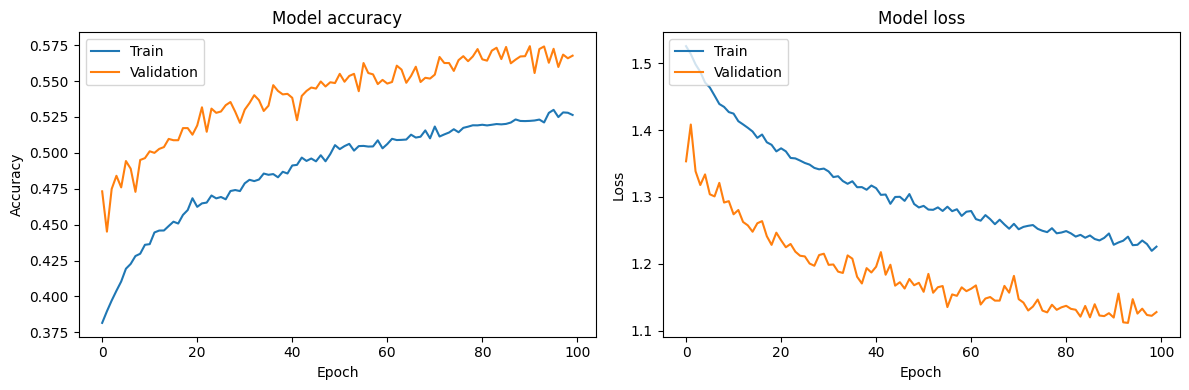

In [63]:

# Plot training & validation accuracy values
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()

Validation

In [64]:
test_loss, test_acc = model.evaluate(validation_generator)
print('Test accuracy:', test_acc)

110/110 [==============================] - 2s 17ms/step - loss: 1.1268 - accuracy: 0.5685
Test accuracy: 0.5685093998908997


In [65]:
# model_save_path = "/content/drive/MyDrive/Deep Learning/emotion_detection_model.h5"
model_save_path = "./model/emotion_detection_model.keras"

In [66]:
model.save(model_save_path)

# testing

In [67]:
test_images_dir = path + "/testing"
file_list = os.listdir(test_images_dir)
print(file_list )

['training1.jpg', 'training2.jpg', 'training3.jpg', 'training4.jpg', 'training5.jpg', 'training6.jpg']


In [68]:
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import numpy as np
import matplotlib.pyplot as plt

In [74]:

class_labels = ['bahagia', 'marah', 'sedih', 'terkejut', 'takut', 'netral']

In [88]:
# model_path = "/content/drive/MyDrive/Deep Learning/emotion_detection_model.h5" #google drive
model_path = model_save_path
# model_path = "./bestModel.keras" #Best Model
model = load_model(model_path)

In [89]:
def predict_image(image_path):
    img = load_img(image_path, target_size=(img_width, img_height))
    img_array = img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = img_array / 255.0  # Normalisasi gambar

    predictions = model.predict(img_array)
    predicted_class = np.argmax(predictions, axis=1)
    return class_labels[predicted_class[0]]

# Step 7: Menampilkan gambar dengan prediksi
def display_predictions(test_images_dir, num_images=5):
    test_image_files = [f for f in os.listdir(test_images_dir) if os.path.isfile(os.path.join(test_images_dir, f))]
    selected_images = np.random.choice(test_image_files, num_images, replace=False)

    plt.figure(figsize=(15, 15))

    for i, image_file in enumerate(selected_images):
        image_path = os.path.join(test_images_dir, image_file)
        predicted_label = predict_image(image_path)

        plt.subplot(1, num_images, i + 1)
        img = load_img(image_path, target_size=(img_width, img_height))
        plt.imshow(img)
        plt.title(f"Prediksi: {predicted_label}")
        plt.axis('off')

    plt.show()



In [90]:
# Step 7: Melakukan prediksi untuk setiap gambar dalam folder testing
test_image_files = [f for f in os.listdir(test_images_dir) if os.path.isfile(os.path.join(test_images_dir, f))]
for image_file in test_image_files:
    image_path = os.path.join(test_images_dir, image_file)
    predicted_label = predict_image(image_path)
    print(f"Gambar: {image_file} -> Prediksi: {predicted_label}")

1/1 [==============================] - 0s 81ms/step
Gambar: training1.jpg -> Prediksi: marah
1/1 [==============================] - 0s 18ms/step
Gambar: training2.jpg -> Prediksi: terkejut
1/1 [==============================] - 0s 19ms/step
Gambar: training3.jpg -> Prediksi: takut
1/1 [==============================] - 0s 16ms/step
Gambar: training4.jpg -> Prediksi: sedih
1/1 [==============================] - 0s 16ms/step
Gambar: training5.jpg -> Prediksi: sedih
1/1 [==============================] - 0s 17ms/step
Gambar: training6.jpg -> Prediksi: sedih


1/1 [==============================] - 0s 15ms/step


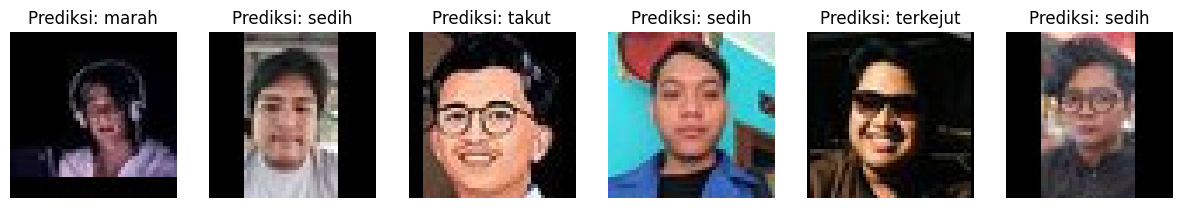

In [91]:
display_predictions(test_images_dir, num_images=6)